In [ ]:
# Choose which function you need and want to test and add them to makina

# kedro features 

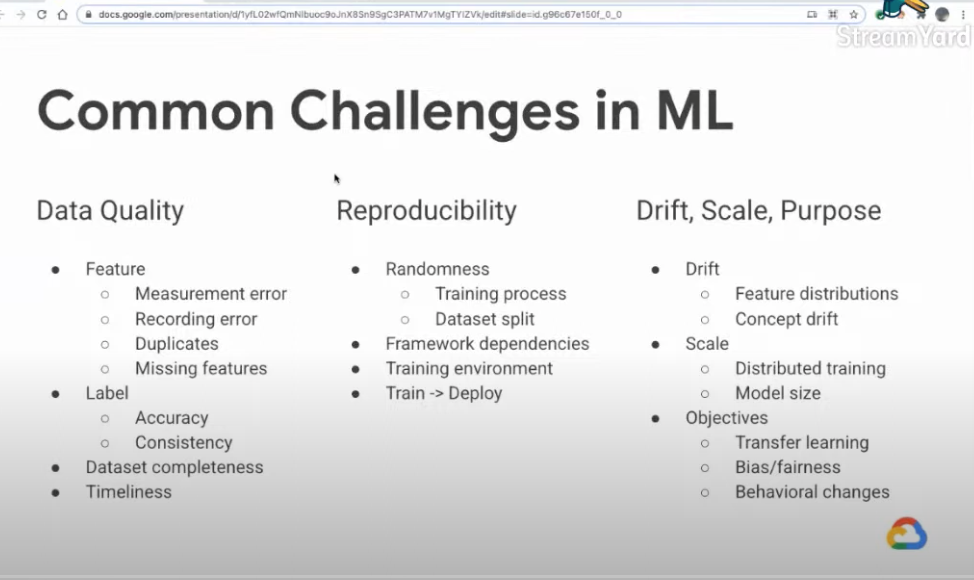

# Plan
1.
2.
3.

# Project Structure:
1. Abstract
2. Load data
3. EDA
4. Preprocess data
5. Feature engineering
6. Train, test split
7. Modelling
8. Model evaluation
9. Hyperparameter tuning 
10. Model Interpretation 
11. Results and conclusions
12. References and Acknowledgments

# My building blocks for modeling 
## - EDA
## - Preprocessing
## - Feature engineering 
## - Training
## - Evaluation

# Abstract

# Import libraries

In [ ]:
import polars as pl
import numpy as np
import pandas as pd
from ydata_profiling import ProfileReport
import polars as pl
import numpy as np
import pandas as pd
from ydata_profiling import ProfileReport
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff

pd.set_option('display.max_columns', None)

# Load data

In [ ]:
catalog.list()

In [ ]:
# Load whole raw data
df = catalog.load("data_from_catalog")

## Load parametrs

In [ ]:
features = catalog.load("params:feature_options")

In [ ]:
features

In [ ]:
# Use only features which are define in ../conf/base/parameters/...
df = df[parameters["features"]]

In [ ]:
# make the function where i am choosing if i am lodaing data throgh kedro catalog or through traditional way from a file and also extension for files

# # Define the path to the Excel file
# file_path = '../data/01_raw/IWA-External-Scope-3-Data.xlsx'
# 
# # Read the Excel file, specifying the sheet name
# df = pd.read_excel(file_path, sheet_name='3%')
# 
# import yaml
# 
# # Define the path to the YAML file
# yaml_file_path = '../conf/base/parameters/data_processing.yml'
# 
# # Load the YAML file
# with open(yaml_file_path, 'r') as file:
#     data_processing_config = yaml.safe_load(file)
# 
# # Extract the features list
# features_list = data_processing_config['feature_options']['features']
# 
# # Construct the desired dictionary format
# features = {'features': features_list}

# EDA

## Data profiling

In [ ]:
# also in this function i want that i am choosing only one column or few columns for that 

def data_profiling(df: pd.DataFrame, name: str="data_profiling_report", interface: str="html") -> None:
  """
  This function generates a data profiling report using the pandas_profiling package.
  
  Args:
      df (pd.DataFrame): The DataFrame to profile.
      name (str, optional): The title of the profile report. Defaults to "data_profiling_report".
      interface (str, optional): The format of the report. Defaults to "html".
                                  Choose between 'html' or 'widget'.
  
  Raises:
      ValueError: If df is not a pandas DataFrame or name is not a string or 
                  if interface is not 'html' or 'widget'
  """
  
  # Check if df is a pandas DataFrame
  if not isinstance(df, pd.DataFrame):
    raise ValueError("df should be a pandas DataFrame")
    
  # Check if name is a string
  if not isinstance(name, str):
    raise ValueError("name should be a string")
  
  # Check if interface is a string and a valid option
  if not isinstance(interface, str) or interface not in ['html', 'widget']:
    raise ValueError("interface should be a string, either 'html' or 'widget'")
  
  profile = ProfileReport(df, title=name, explorative=True)

  if interface == "html":
    profile.to_file(f"{name}.html")
    logging.info(f"Report {name} generated in html format, check files.")
    
  elif interface == "widget":
    logging.info(f"Report {name} will be generated as a widget, it might take a while.")
    profile.to_widgets()

In [ ]:
# Generate the data profiling report in HTML format
# data_profiling(df)

In [ ]:
# maybe I will write function which will generate diffrent plotly graphs 

In [ ]:
# also add steps based on book basics statistics 

# Preprocessing

## Remove rows with missing values

In [ ]:
# Count missing values in each column
missing_values_per_column = df.isna().sum()
print("Missing values per column:")
print(missing_values_per_column)

# Count total missing values in the DataFrame
total_missing_values = df.isna().sum().sum()
print(f"Total missing values: {total_missing_values}")

In [ ]:
from typing import List, Union

def _remove_rows_with_missing_values(df: pd.DataFrame, columns: Union[str, List[str]] = None) -> pd.DataFrame:
    """
    Remove all rows containing missing values either from the whole DataFrame or from specific columns.

    Args:
        df (pd.DataFrame): Input DataFrame.
        columns (Union[str, List[str]], optional): Column or list of columns to consider for row removal. 
                                                   If None, consider all columns. Default is None.
    
    Returns:
        pd.DataFrame: DataFrame with rows containing missing values removed.
    """
    
    if columns is not None:
        return df.dropna(subset=columns)
    else:
        return df.dropna()

In [ ]:
# Remove rows with missing values from whole DataFrame
# df = _remove_rows_with_missing_values(df)

# Remove rows with missing values only from columns A and B
# df = _remove_rows_with_missing_values(df, columns=['A', 'B'])

## Impute missing values

### Simple impution with mean, median or zero

In [ ]:
from typing import List, Union

def _impute_missing_values(df: pd.DataFrame, columns: Union[List[str], str], strategy: str = 'mean') -> pd.DataFrame:
    """
    Impute missing values in specific columns of a DataFrame.

    Args:
        df (pd.DataFrame): Input DataFrame.
        columns (Union[List[str], str]): Column or columns in which to impute missing values.
        strategy (str, optional): The imputation strategy. Options are 'mean', 'median', 'mode', and 'zero'. Defaults to 'mean'.

    Returns:
        pd.DataFrame: DataFrame with missing values imputed in the specified columns.
    """

    if not isinstance(columns, list):
        columns = [columns]
        
    for column in columns:
        if strategy == 'mean':
            df[column].fillna(df[column].mean(), inplace=True)
        elif strategy == 'median':
            df[column].fillna(df[column].median(), inplace=True)
        elif strategy == 'mode':
            df[column].fillna(df[column].mode()[0], inplace=True)
        elif strategy == 'zero':
            df[column].fillna(0, inplace=True)

    return df

In [1]:
# Impute missing values in columns 'A' and 'B' using the 'mean' strategy
# df_imputed = _impute_missing_values(df.copy(), ['A', 'B'], 'mean')

## Regression imputation

In [ ]:
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd

def regression_impute(df: pd.DataFrame, target_column: str, feature_columns: list) -> pd.DataFrame:
    """
    Impute missing values in a target column using regression on feature columns.

    Args:
        df (pd.DataFrame): Input DataFrame.
        target_column (str): The column in which to impute missing values.
        feature_columns (list): List of feature columns to use for imputation.

    Returns:
        pd.DataFrame: DataFrame with missing values imputed in the target column.
    """
    
    # Create separate dataframes for rows with missing and non-missing target values
    df_missing = df[df[target_column].isna()]
    df_not_missing = df.dropna(subset=[target_column])
    
    # Separate features and target for rows without missing target values
    X_train = df_not_missing[feature_columns]
    y_train = df_not_missing[target_column]
    
    # Fit a linear regression model
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Predict target values for rows with missing target values
    X_missing = df_missing[feature_columns]
    y_pred = model.predict(X_missing)
    
    # Impute the predicted values back into the original dataframe
    df.loc[df[target_column].isna(), target_column] = y_pred

    return df


In [ ]:
# Example usage:
# Assume df is your DataFrame, 'age' is the column with missing values and ['income', 'education'] are features.
# df = regression_impute(df, 'age', ['income', 'education'])

## Outliers detection

In [2]:
from sklearn.ensemble import IsolationForest

def _remove_outliers_isolation_forest(df: pd.DataFrame, contamination: float = 0.2) -> pd.DataFrame:
    """
    Remove outliers using the Isolation Forest algorithm.

    Args:
        df (pd.DataFrame): Input DataFrame with numerical columns.
        contamination (float): Proportion of outliers in the dataset.
    
    Returns:
        pd.DataFrame: DataFrame with outliers removed.
    """

    # Identify numerical columns
    numerical_cols = df.select_dtypes(include=['number']).columns

    # Initialize the IsolationForest model
    clf = IsolationForest(contamination=contamination) 

    # Fit the model on numerical columns
    clf.fit(df[numerical_cols])

    # Get outlier predictions
    outlier_predictions = clf.predict(df[numerical_cols])

    # Remove outliers from the original DataFrame based on the predictions
    df_filtered = df[outlier_predictions == 1]

    return df_filtered

NameError: name 'pd' is not defined

In [ ]:
def preprocess_data(data: pd.DataFrame, parameters: Dict) -> pd.DataFrame:
    """Preprocesses data.

    Args:
        data: Raw data.
        
    Returns:
        Preprocessed data, with missing values removed.
    """
    # Example
    df = data[parameters["features"]]
    df = _remove_missing_values(df)
    df = _remove_outliers_isolation_forest(df)
    preprocessed_data = df
    
    return preprocessed_data

In [ ]:
preprocessed_df = preprocess_data(df, features)

# Feature engineering

## Encoding Categorical Variables

In [ ]:
def _one_hot_encode(df: pd.DataFrame) -> pd.DataFrame:
    # One-hot encode 'Country' and 'Industry (Exiobase)' columns
    df_encoded = pd.get_dummies(df, columns=['Industry (Exiobase)'])
    return df_encoded

## Normalization/Standardization 

In [ ]:
def _normalization(df: pd.DataFrame) -> pd.DataFrame:
    # Create the scaler
    scaler_standard = StandardScaler()

    # Fit the scaler to the data (excluding categorical data if not already encoded)
    df_normalized_standard = pd.DataFrame(scaler_standard.fit_transform(df), columns=df.columns)
    
    return df_normalized_standard

In [ ]:
def feature_engineering(df: pd.DataFrame) -> pd.DataFrame:
    """
    Conducts feature engineering on the given DataFrame.

    Steps:
    1. One-Hot Encoding: One-hot encodes categorical features.
    2. Normalization: Standardizes the feature values.
    ...

    Args:
        df: Original DataFrame.

    Returns:
        df_feature_engineered: DataFrame after feature engineering.
    """

    df = _one_hot_encode(df)
    df = _normalization(df)
    df_feature_engineered = df

    return df_feature_engineered

In [ ]:
df_feature_engineered = feature_engineering(preprocessed_df)

# Training

## Train, test split

In [ ]:
def split_data(data: pd.DataFrame, model_options: Dict) -> Tuple:
    """Splits data into features and targets training and test sets.

    Args:
        data: Data containing features and target.
        parameters: Parameters defined in parameters/data_science.yml.
    Returns:
        Split data.
    """
    # X = data[parameters["features"]]
    X = data[parameters["features"]].drop("Scope 3", axis=1)
    y = data["Scope 3"]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=parameters["test_size"], random_state=parameters["random_state"]
    )
    return X_train, X_test, y_train, y_test

In [ ]:
parameters = catalog.load("params:model_options")

In [ ]:
# Assuming df_feature_engineered is your DataFrame and parameters is your configuration dictionary
X_train, X_test, y_train, y_test = split_data(df_feature_engineered, parameters)

## Train

## AutoML modeling

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
import logging
import pandas as pd
from typing import Any

def train_model(X_train: pd.DataFrame, y_train: pd.Series) -> Any:
    """Trains the XGBoost model.
    
    Args:
        X_train: Training data of independent features.
        y_train: Training data for target variable.
        
    Returns:
        Trained model.
    """
    params = {
        'alpha': 9.418025790529975e-05,
        'colsample_bytree': 0.73850137825373,
        'eta': 0.03756810920990241,
        'gamma': 1.8103086083962833e-05,
        'lambda': 0.006052853661670603,
        'max_depth': 4,
        'min_child_weight': 1.0000000000000004e-06,
        'objective': 'reg:squarederror',
        'subsample': 0.8954379516782436,
        'eval_metric': ['rmse', 'mae']
    }
    dtrain = xgb.DMatrix(X_train, label=y_train)
    model = xgb.train(params, dtrain, num_boost_round=674)
    return model

In [ ]:
# Train the model
trained_model = train_model(X_train, y_train)

# Evaluation

In [ ]:
def evaluate_model(model: Any, X_test: pd.DataFrame, y_test: pd.Series):
    """Calculates and logs the coefficient of determination and RMSE.
    
    Args:
        model: Trained XGBoost model.
        X_test: Testing data of independent features.
        y_test: Testing data for target variable.
    """
    dtest = xgb.DMatrix(X_test, label=y_test)
    y_pred = model.predict(dtest)
    score = r2_score(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    
    print(f"Model has a coefficient R^2 of {score:.3f} on test data.")
    print(f"Model has a RMSE of {rmse:.3f} on test data.")
    
    logger = logging.getLogger(__name__)
    logger.info(f"Model has a coefficient R^2 of {score:.3f} on test data.")
    logger.info(f"Model has a RMSE of {rmse:.3f} on test data.")

In [ ]:
# Evaluate the model
evaluate_model(trained_model, X_test, y_test)

# Hyperparameter tuning

# Model Interpretation

# Results and conclusions

# References and Acknowledgments
```